Prepare data

In [4]:
# for SHAP values
import shap
# lightgbm for the LightGBM model (GBM - Gradient Boost Model)
import lightgbm as lgb
# train_test_split for splitting the data into training and testing sets.
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
# Load data

# Load the 'adult' dataset from SHAP.
# X contains the feature matrix, and y contains the target variable.
X, y = shap.datasets.adult()
# for displaying purposes
X_display, y_display = shap.datasets.adult(display=True)
# num_features holds the number of features in the dataset.
num_features = X.shape[1]

# Split data

# Split the data into training and testing sets, with 20% of the data used for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
# Convert the training and testing sets into LightGBM datasets.
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

Train model

In [7]:
# Train model

# Define the parameters for training the LightGBM model
params = {
    # max_bin: Maximum number of bins for discretizing continuous features.
    "max_bin": 512,
    # learning_rate: Step size for updating weights.
    "learning_rate": 0.05,
    # boosting_type: Type of boosting (Gradient Boosting Decision Tree).
    "boosting_type": "gbdt",
    # objective: Binary classification objective.
    "objective": "binary",
    # metric: Metric for evaluating performance (binary log-loss).
    "metric": "binary_logloss",
    # num_leaves: Maximum number of leaves in one tree.
    "num_leaves": 10,
    # verbose: Verbosity level.
    "verbose": -1,
    # min_data: Minimum number of data points in a leaf.
    "min_data": 100,
    # boost_from_average: Whether to use average value to initialize boosting.
    "boost_from_average": True
}

# Train the LightGBM model with the specified parameters and the training data.
# The training stops early if the validation score doesn't improve for 50 rounds. The best iteration is stored.
model = lgb.train(params, d_train, num_boost_round=10000, valid_sets=[d_test], callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=1000)])

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.278029


Generate explanations

In [12]:
# numpy for numerical operations
import numpy as np
# matplotlib.pyplot for plotting.
import matplotlib.pyplot as plt
# specific modules from rexplain for generating explanations.
from rexplain import removal, behavior, summary

In [13]:
# create lambda function model_lam
# that makee model callable with numpy inputs
model_lam = lambda x: model.predict(x)

# create a marginal extension of the model
# using the removal module and the test data.
marginal_extension = removal.MarginalExtension(X_test.values[:512], model_lam)

# Create a cooperative game instance for the prediction behavior of the model
# using the first data point in the dataset.
game = behavior.PredictionGame(marginal_extension, X.iloc[0, :].values)

CPU times: user 219 ms, sys: 1.59 ms, total: 220 ms
Wall time: 131 ms


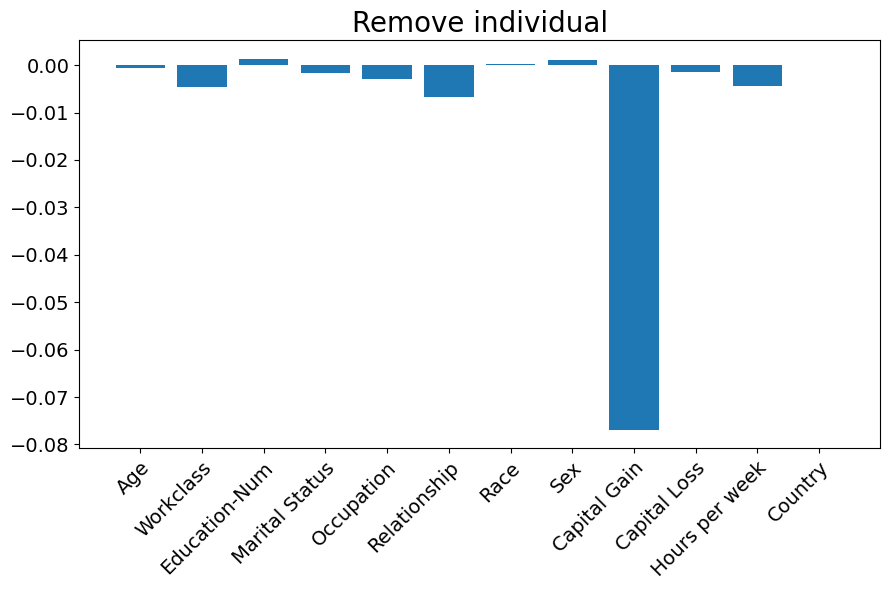

In [14]:
# Summary technique

# Applying the RemoveIndividual summary technique to the game and measure the time taken

%time attr = summary.RemoveIndividual(game)

# Plotting the feature attributions obtained from the RemoveIndividual summary technique.

plt.figure(figsize=(9, 6))
plt.bar(np.arange(len(attr)), attr)
plt.xticks(np.arange(len(attr)), X.columns,
           rotation=45, rotation_mode='anchor',
           ha='right', fontsize=14)
plt.tick_params(labelsize=14)
plt.title('Remove individual', fontsize=20)
plt.tight_layout()
plt.show()

CPU times: user 264 ms, sys: 0 ns, total: 264 ms
Wall time: 143 ms


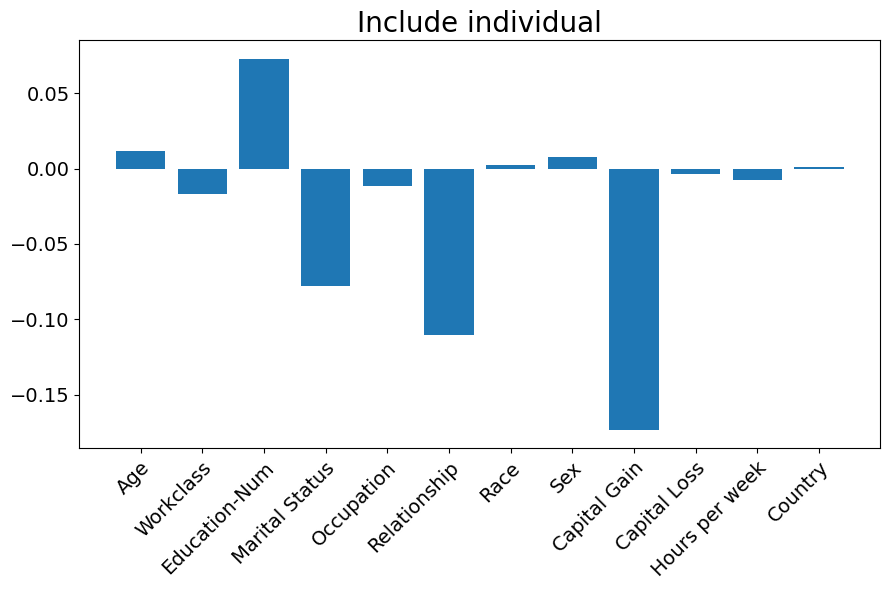

In [15]:
# Summary technique

# Applying the IncludeIndividual summary technique to the game and measure the time taken.

%time attr = summary.IncludeIndividual(game)

# Plotting the feature attributions obtained from the IncludeIndividual summary technique.

plt.figure(figsize=(9, 6))
plt.bar(np.arange(len(attr)), attr)
plt.xticks(np.arange(len(attr)), X.columns,
           rotation=45, rotation_mode='anchor',
           ha='right', fontsize=14)
plt.tick_params(labelsize=14)
plt.title('Include individual', fontsize=20)
plt.tight_layout()
plt.show()

CPU times: user 2min 4s, sys: 580 ms, total: 2min 5s
Wall time: 1min 19s


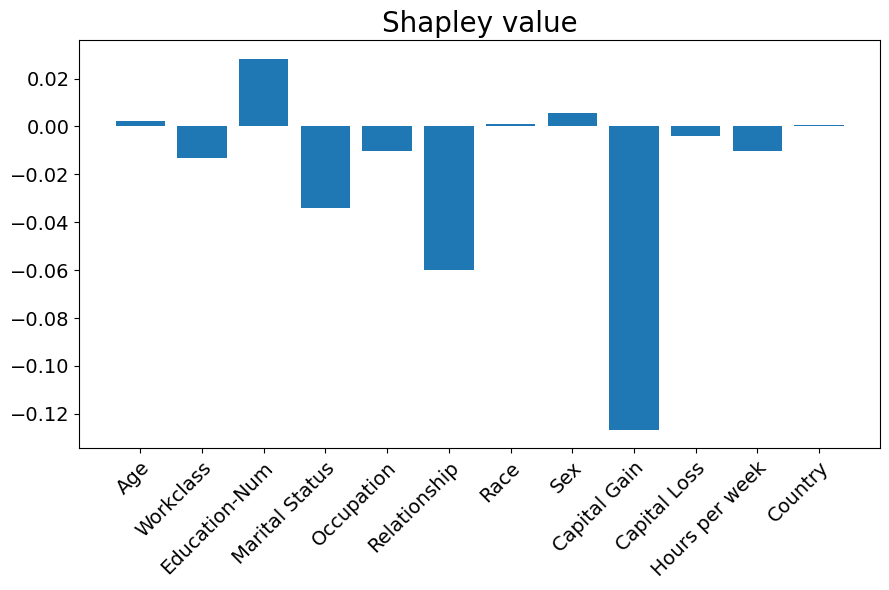

In [16]:
# Summary technique

# Applying the ShapleyValue summary technique to the game and measure the time taken.
%time attr = summary.ShapleyValue(game)

# Plotting the feature attributions obtained from the ShapleyValue summary technique.
plt.figure(figsize=(9, 6))
plt.bar(np.arange(len(attr)), attr)
plt.xticks(np.arange(len(attr)), X.columns,
           rotation=45, rotation_mode='anchor',
           ha='right', fontsize=14)
plt.tick_params(labelsize=14)
plt.title('Shapley value', fontsize=20)
plt.tight_layout()
plt.show()